In [1]:
import numpy as np
import pandas as pd

import xgboost

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

from sklearn.preprocessing import RobustScaler

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [2]:
shap.initjs()

In [3]:
import os
os.getcwd()

'D:\\WBproj\\proj2\\DNN'

In [4]:
train_icu = pd.read_csv("../data/splitted/icu_train.csv").iloc[:, 1:]
test_icu = pd.read_csv("../data/splitted/icu_test.csv").iloc[:, 1:]

rs_icu = RobustScaler()

X_train_icu = np.array(train_icu.iloc[:, :-1])
X_train_icu_scaled = rs_icu.fit_transform(np.array(train_icu.iloc[:, :-1]))
y_train_icu = np.array(train_icu.iloc[:, -1])

X_test_icu = np.array(test_icu.iloc[:, :-1])                
X_test_icu_scaled = rs_icu.transform(np.array(test_icu.iloc[:, :-1]))
y_test_icu = np.array(test_icu.iloc[:, -1])

In [5]:
train_exp = pd.read_csv("../data/splitted/expired_train.csv").iloc[:, 1:]
test_exp = pd.read_csv("../data/splitted/expired_test.csv").iloc[:, 1:]

rs_exp = RobustScaler()

X_train_exp = np.array(train_exp.iloc[:, :-1])
X_train_exp_scaled = rs_exp.fit_transform(np.array(train_exp.iloc[:, :-1]))

y_train_exp = np.array(train_exp.iloc[:, -1])

X_test_exp = np.array(test_exp.iloc[:, :-1])
X_test_exp_scaled = rs_exp.transform(np.array(test_exp.iloc[:, :-1]))

y_test_exp = np.array(test_exp.iloc[:, -1])

In [6]:
def make_article_layer(neurons, **kwargs):
    return Dense(neurons, activation="relu", kernel_initializer="he_normal", kernel_regularizer="l2", **kwargs)

def make_article_model(loss="mean_squared_error", input_shape=(5,)):
    # The DNN model used five hidden layers with 6, 8, 16, 8, 4 neurons respectively.
    model = Sequential()
    model.add(make_article_layer(6, input_shape=input_shape))
    model.add(make_article_layer(8))
    model.add(make_article_layer(16))
    model.add(make_article_layer(8))
    model.add(make_article_layer(4))
    # [...] the sigmoid activation function for the output layer, and the “he_normal” normalization scheme were applied. 
    model.add(Dense(1, activation="sigmoid", kernel_initializer="he_normal", kernel_regularizer="l2"))
    model.compile(optimizer="adam", loss=loss, metrics=["accuracy"])
    return model

def make_modified(input_shape=(5,)):
    return make_article_model(input_shape=input_shape, loss="binary_crossentropy")

def make_basic(input_shape=(5,)):
    wider = Sequential()
    wider.add(Dense(32, activation="relu", input_shape=input_shape))
    wider.add(Dense(32, activation="relu"))
    wider.add(Dense(1, activation="sigmoid"))
    wider.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return wider

In [7]:
def calc_roc_keras(model, X_test, y_test): 
    y_pred_keras = model.predict(X_test).ravel()
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
    return fpr_keras, tpr_keras

In [8]:
def plot_rocs(rates: [(np.array, np.array)], names):
    plotted_aucs = []
    for fpr, tpr in rates:
        plt.plot(fpr, tpr)
        plotted_aucs.append(auc(fpr, tpr))
    plt.legend([f"{name} AUC: {area:.3f}" for name, area in zip(names, plotted_aucs)], loc="lower right")
    plt.plot([0,1], [0,1], "r--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")

In [9]:
def make_and_fit_keras(constructor, X_train, y_train, icu=True):
    if icu:
        input_shape=(5,)
    else:
        input_shape=(6,)
    model = constructor(input_shape=input_shape)
    model.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=0)
    return model

# Expired models

In [10]:
exp_article_model = make_and_fit_keras(make_article_model, X_train_exp_scaled, y_train_exp, icu=False)
exp_basic_model = make_and_fit_keras(make_basic, X_train_exp_scaled, y_train_exp, icu=False)
exp_modified_model = make_and_fit_keras(make_modified, X_train_exp_scaled, y_train_exp, icu=False)

In [11]:
exp_xgb = xgboost.XGBClassifier()
exp_xgb.load_model('../models/xgb_expired.model')

Loading a native XGBoost model with Scikit-Learn interface.


<Figure size 560x350 with 0 Axes>

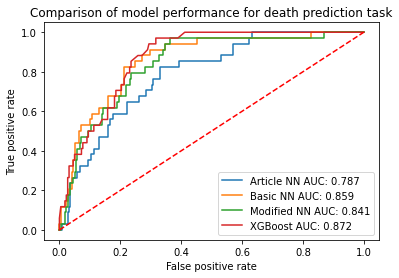

In [12]:
plt.figure(figsize=(8,5), dpi= 70)
fig, ax = plt.subplots()
ax = plot_rocs(
    [
        calc_roc_keras(exp_article_model, X_test_exp_scaled, y_test_exp),
        calc_roc_keras(exp_basic_model, X_test_exp_scaled, y_test_exp),
        calc_roc_keras(exp_modified_model, X_test_exp_scaled, y_test_exp),
        roc_curve(y_test_exp, exp_xgb.predict_proba(X_test_exp)[:,1])[0:2]
    ],
    ["Article NN", "Basic NN", "Modified NN", "XGBoost"]
)
plt.title("Comparison of model performance for death prediction task")
plt.show()
fig.savefig('5-4-mortality_comparison.png')

In [13]:
# calculating shap values for whole sets and all models
explainer_exp_article_model = shap.KernelExplainer(exp_article_model.predict, X_train_exp_scaled)
explainer_exp_basic_model = shap.KernelExplainer(exp_basic_model.predict, X_train_exp_scaled)
explainer_exp_modified_model = shap.KernelExplainer(exp_modified_model.predict, X_train_exp_scaled)
explainer_exp_xgb = shap.Explainer(exp_xgb)

Using 765 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 765 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 765 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [14]:
X_exp_scaled = np.concatenate((X_train_exp_scaled, X_test_exp_scaled), axis=0)
X_exp = np.concatenate((X_train_exp, X_test_exp), axis=0)

In [15]:
shaps_exp_article_model = explainer_exp_article_model.shap_values(X_exp_scaled)
shaps_exp_basic_model = explainer_exp_basic_model.shap_values(X_exp_scaled)
shaps_exp_modified_model = explainer_exp_modified_model.shap_values(X_exp_scaled)
shaps_exp_xgb = explainer_exp_xgb(X_exp)

In [20]:
shaps_exp_article_model

[array([[ 6.36160114e-07,  1.21879798e-05,  5.36126119e-06,
         -6.45416430e-06, -8.63039544e-04, -3.56204629e-07],
        [-7.74655791e-06, -2.41344856e-06,  1.19985546e-05,
         -1.35626019e-06, -1.01144331e-03, -4.14131514e-07],
        [-6.16830159e-07,  5.60000571e-07, -4.74039311e-06,
          1.17917076e-06, -1.10808445e-03, -2.55498102e-07],
        ...,
        [ 3.15725544e-06,  1.74306752e-05,  4.79892851e-05,
         -1.21718463e-06,  3.88761773e-03,  2.20086645e-06],
        [ 5.12700000e-06, -1.43259069e-05,  3.45329833e-06,
         -3.47331134e-06, -1.03441102e-03,  2.86968900e-06],
        [ 6.59455726e-06, -8.34884012e-06, -8.37781525e-06,
          1.81192926e-07, -1.52097542e-05,  1.13644242e-06]])]

In [21]:
shaps_exp_xgb

.values =
array([[-3.4979463e-02,  2.2424761e-02, -2.3836106e-02, -8.1997383e-03,
         9.3885642e-03, -1.7256990e-02],
       [-1.0167508e-01,  1.0104405e-03,  3.9324470e-02, -2.4216434e-03,
        -2.3355875e-02, -1.7315390e-02],
       [-3.5788827e-02,  1.6677659e-06, -2.1371178e-02, -3.8256235e-03,
        -9.2627592e-03, -1.1867065e-02],
       ...,
       [ 5.8299482e-02,  1.8912427e-02,  3.0027685e-01, -2.0346470e-02,
         1.3145195e-01,  1.6320038e-01],
       [ 1.3648984e-01, -9.0383217e-02,  5.0923042e-02,  4.1414388e-02,
         1.5111512e-02,  2.9082605e-01],
       [ 7.1062908e-02, -1.3208531e-02, -1.2209216e-01, -1.1282191e-02,
        -1.6158599e-02,  1.0749608e-01]], dtype=float32)

.base_values =
array([0.20097223, 0.20097223, 0.20097223, ..., 0.20097223, 0.20097223,
       0.20097223], dtype=float32)

.data =
array([[6.400e+01, 1.810e+01, 4.630e+02, 9.300e+01, 3.200e-01, 1.000e-02],
       [2.800e+01, 9.700e+00, 5.610e+02, 9.200e+01, 1.700e-01, 1.000e-02],
  

In [22]:
shaps_exp_modified_model

[array([[-9.94406096e-03,  1.15399569e-02,  1.40114848e-02,
         -3.49847061e-03, -1.55992991e-02, -2.67804041e-04],
        [-1.08685710e-01, -2.19367104e-03,  1.97139322e-02,
          2.01510773e-06, -2.60787359e-02, -1.64915132e-04],
        [-3.44428977e-02,  2.80630065e-04, -2.04651098e-02,
          4.48889593e-03, -3.80002582e-02, -1.92960557e-04],
        ...,
        [ 3.62415291e-02,  9.92380350e-03,  9.98729766e-02,
         -2.25368444e-03,  1.98461232e-01,  7.05201933e-04],
        [ 9.48337135e-02, -1.67174091e-02,  1.05812771e-02,
         -3.92598281e-02, -3.06403342e-02,  1.96660301e-03],
        [ 1.49302571e-01, -1.04281947e-02, -3.41895316e-02,
         -1.88756706e-02,  8.08998728e-02,  7.17657073e-04]])]

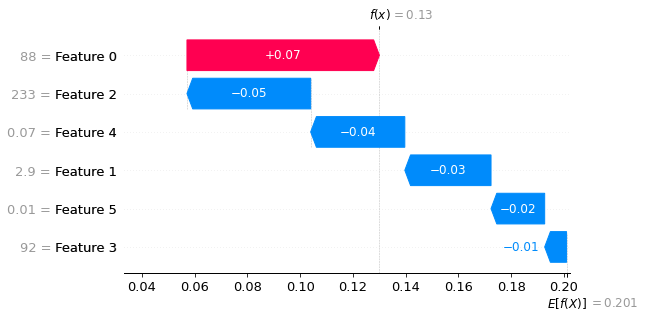

In [91]:
shap.plots.waterfall(shaps_exp_xgb[17])

In [ ]:
shap.plots.waterfall(shaps_exp_modified_model[0])

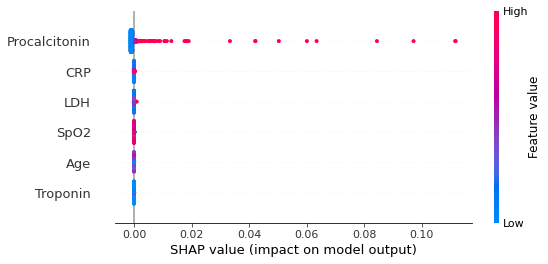

In [28]:
shap.summary_plot(shaps_exp_article_model[0], X_exp_scaled, train_exp.columns[:-1])

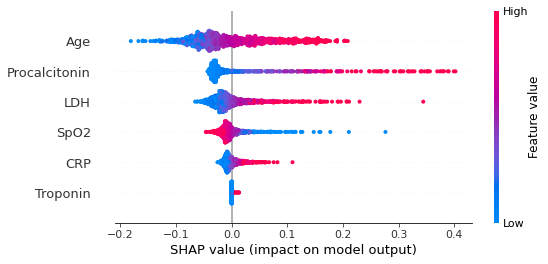

In [29]:
shap.summary_plot(shaps_exp_modified_model[0], X_exp_scaled, train_exp.columns[:-1])

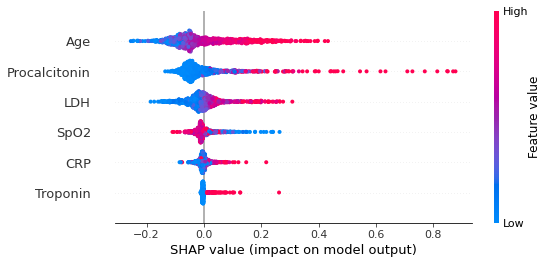

In [30]:
shap.summary_plot(shaps_exp_basic_model[0], X_exp_scaled, train_exp.columns[:-1])

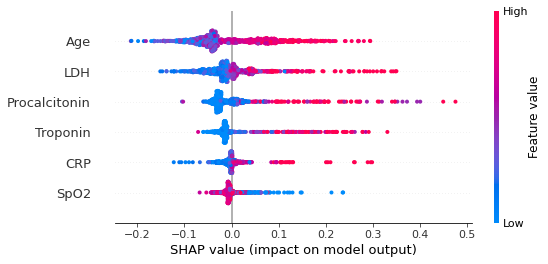

In [59]:
shap.summary_plot(shaps_exp_xgb, feature_names=train_exp.columns[:-1])

In [32]:
shap.plots.force(explainer_exp_article_model.expected_value, shaps_exp_article_model[0][17], train_exp.columns[:-1])

In [33]:
shap.plots.force(explainer_exp_modified_model.expected_value, shaps_exp_modified_model[0][17], train_exp.columns[:-1])

In [77]:
shap.plots.force(explainer_exp_basic_model.expected_value, shaps_exp_basic_model[0][17], feature_names=train_exp.columns[:-1])

In [76]:
shap.plots.force(shaps_exp_xgb[17],feature_names= train_exp.columns[:-1]) #tu ładnie się podpisuje, ale dla nn już nie

In [35]:
shap.plots.force(explainer_exp_article_model.expected_value, shaps_exp_article_model[0])

In [36]:
shap.plots.force(explainer_exp_modified_model.expected_value, shaps_exp_modified_model[0])

In [41]:
shap.plots.force(explainer_exp_basic_model.expected_value, shaps_exp_basic_model[0])

In [83]:
shap.plots.force(explainer_exp_xgb.expected_value, shaps_exp_xgb.values)

In [68]:
explainer_exp_xgb.expected_value

0.20097223

In [ ]:
shap.dependence_plot("Feature 1", shaps_exp_modified_model[0], X_exp_scaled)

In [ ]:
shaps_exp_modified_model[0]

# ICU models

In [42]:
icu_article_model = make_and_fit_keras(make_article_model, X_train_icu_scaled, y_train_icu)
icu_basic_model = make_and_fit_keras(make_basic, X_train_icu_scaled, y_train_icu)
icu_modified_model = make_and_fit_keras(make_modified, X_train_icu_scaled, y_train_icu)

In [43]:
icu_xgb = xgboost.XGBClassifier()
icu_xgb.load_model('../models/xgb_icu.model')

Loading a native XGBoost model with Scikit-Learn interface.


<Figure size 560x350 with 0 Axes>

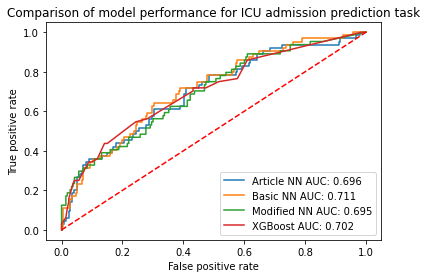

In [44]:
plt.figure(figsize=(8,5), dpi= 70)
fig, ax = plt.subplots()
ax=plot_rocs(
    [
        calc_roc_keras(icu_article_model, X_test_icu_scaled, y_test_icu),
        calc_roc_keras(icu_basic_model, X_test_icu_scaled, y_test_icu),
        calc_roc_keras(icu_modified_model, X_test_icu_scaled, y_test_icu),
        roc_curve(y_test_icu, icu_xgb.predict_proba(X_test_icu)[:,1])[0:2]
    ],
    ["Article NN", "Basic NN", "Modified NN", "XGBoost"]
)
plt.title("Comparison of model performance for ICU admission prediction task")
plt.show()
fig.savefig('5-4-icu_comparison.png')

In [45]:
# calculating shap values for whole sets and all models
explainer_icu_article_model = shap.KernelExplainer(icu_article_model.predict, X_train_icu_scaled)
explainer_icu_basic_model = shap.KernelExplainer(icu_basic_model.predict, X_train_icu_scaled)
explainer_icu_modified_model = shap.KernelExplainer(icu_modified_model.predict, X_train_icu_scaled)
explainer_icu_xgb = shap.Explainer(icu_xgb)

X_icu_scaled = np.concatenate((X_train_icu_scaled, X_test_icu_scaled), axis=0)
X_icu = np.concatenate((X_train_icu, X_test_icu), axis=0)

shaps_icu_article_model = explainer_icu_article_model.shap_values(X_icu_scaled)
shaps_icu_basic_model = explainer_icu_basic_model.shap_values(X_icu_scaled)
shaps_icu_modified_model = explainer_icu_modified_model.shap_values(X_icu_scaled)
shaps_icu_xgb = explainer_icu_xgb(X_icu)

Using 829 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 829 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 829 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [47]:
shap.plots.force(explainer_icu_article_model.expected_value, shaps_icu_article_model[0][17], train_icu.columns[:-1])

In [48]:
shap.plots.force(explainer_icu_modified_model.expected_value, shaps_icu_modified_model[0][17], train_icu.columns[:-1])

In [72]:
shap.plots.force(explainer_icu_basic_model.expected_value, shaps_icu_basic_model[0][17], feature_names=train_icu.columns[:-1])

In [70]:
shap.plots.force(shaps_icu_xgb[17], feature_names=train_icu.columns[:-1])

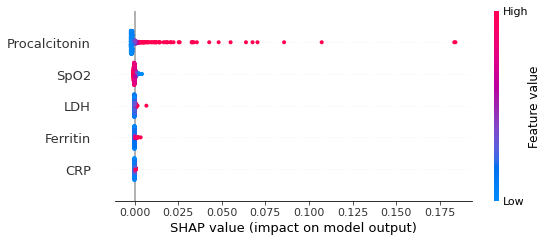

In [50]:
shap.summary_plot(shaps_icu_article_model[0], X_icu_scaled, train_icu.columns[:-1])

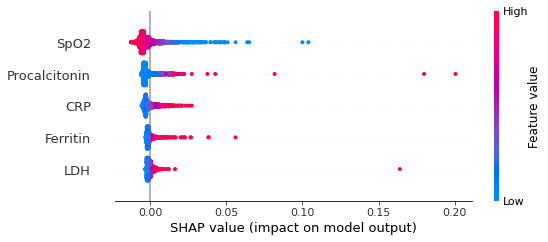

In [51]:
shap.summary_plot(shaps_icu_modified_model[0], X_icu_scaled, train_icu.columns[:-1])

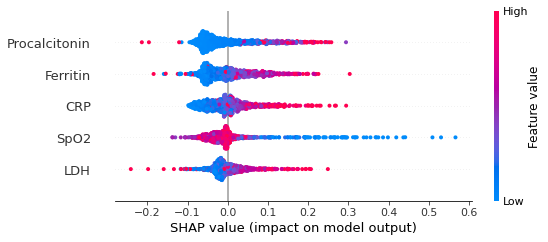

In [52]:
shap.summary_plot(shaps_icu_basic_model[0], X_icu_scaled, train_icu.columns[:-1])

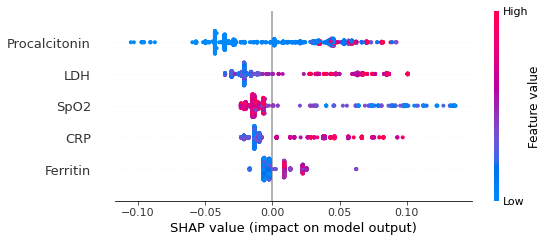

In [60]:
shap.summary_plot(shaps_icu_xgb, feature_names=train_icu.columns[:-1])

In [53]:
shap.plots.force(explainer_icu_article_model.expected_value, shaps_icu_article_model[0])

In [54]:
shap.plots.force(explainer_icu_modified_model.expected_value, shaps_icu_modified_model[0])

In [55]:
shap.plots.force(explainer_icu_basic_model.expected_value, shaps_icu_basic_model[0])

In [84]:
shap.plots.force(explainer_icu_xgb.expected_value, shaps_icu_xgb.values)